# Bayesian Inference 1: Project Report

### Title: "Denoising sc-RNA-seq Data"

### Name: "Najwa Laabid"


## Abstract

> sc-RNA-seq data suffers from noise due to technical limitations (such as amplification and shallow sequencing) and experimental errors. Noise appears in the count matrix in the form of false 0 counts known as *dropout*. Substituting the noise data with extrapolated values (a process known as *imputation* in statistics) increases the reliability of biological inference tasks. In this project, we explore the use of a deep-autoencoder model on the task of dropout identification and imputation in sc-RNA-seq data. The model is used to estimate the parameters of the assumed noise distribution, taken to be zero-inflated negative binomial (ZINB) in this study. We evaluate the method by demonstrating its ability to reveal cell type clusters from a noise-ridden dataset. 



## Introduction


**Introduce your dataset, then the related problem or question, and the hypothesis for solving the issue.**

**About sc-RNA-seq data**: sc-RNA-seq (single-cell RNA sequencing) is a technology for counting the spliced and unspliced molecules within a single cell. The output is usually a matrix of size *cells x genes*. This data can be used in multiple bioinformatics' tasks, such as cell tarjectory inference and whole-genome sequencing.

**Dataset**: We use two datasets in this project:

- **Genes** (from 'data/genes.csv'): a sc-RNA-seq counts matrix with 338 cells and 5000 genes (after preprocessing). 
- **Simraw2** (from 'data/simraw2.pickle'): a dataset simulated using the *splatter* tool [4]. The data contains a noise-ridden set with cells from two distinct groups. The ground truth for the dataset (in the form of noise-free data) can be found in 'data/simtrue2.pickle'. 

**Problem**: sc-RNA-seq counts are prone to technical limitations and errors . As a result, molecular counts may be overlooked, i.e. showing as 0 in the counts matrix when they have a positive value in truth indicating an expressed gene. Identifying the fake zero counts (known as *dropout*), and replacing them with gene or cell-level extrapolated values (process known as *imputation*), is known as *denoising*, and is the focus of this project.

**Hypothetical solution**: One way to identify dropout is to fit an assumed noise model for every gene, then estimate the real counts from the mean of the distribution. The noise model assumed in this project is the zero-inflated negative binomial, which is a popular mixture model for read-based sc-RNA-seq methods ([2] & [3]).

**Bonus points if you could provide short information of other approaches to the same problem**

Other scRNA-seq denoising methods include:
- *scImpute* [7]: identifies and substitues likely dropout values using a mixture model. The method substitutes the dropout values alone, while this current solution provides real count estimates for all values.
- *MAGIC* [5]: uses a Markov Affinity-based Graph to compute the imputations.
- *SAVER* [6]: focuses on UMI-based sc-RNA-seq data. This project targets read-based methods instead.

Existing methods scale poorly with large data, while auto-encoders based inferences was shown to scale linearly with the input [1].

**Introduce your method for building the model, short explain why given method is selected, what is it merits**

We use a deep auto-encoder model to infer the parameters of the noise distribution. To do so, we replace the loss function of the model (usually taken as mean-squared error (MSE)) by the likelihood function of ZINB. We then train the model to estimate the parameters of the distribution which would minimize the likelihood. The model outputs 3 values, one for each parameter of ZINB:
- $\pi$: the probability of a count value being a dropout. 
- $\mu$: the mean value we will use to impute identified dropouts (parameter of negative binomial).
- $\lambda$: the dispersion parameter for every dropout value (parameter of negative binomial).

Auto-encoders are chosen for their ability to handle large input and capture cross-gene dependencies through compression. 

**Some text about the code packages you are going to use for the project (which language and libraries are used)**

The project is implemented in Python3. The following libraries were used:

- For data preprocessing and manipulation: Numpy (v1.19.4), Pandas(v1.1.5),  and AnnData(v0.7.5).
- For visualizations: Matplotlib (v3.2.2), Scanpy (v1.6.0).
- For building the model: Keras (v2.4.3) and Tensorflow (v2.4.0).

**What is the goal you want to achieve after fininshing the project**

* Explore the problem of scRNA-seq denoising and how it can be solved with auto-encoders.
* Learn how to implement the auto-encoder framework following the descriptions given in [1].
* Understand the Bayesian statistical concepts behind the framework and how they're used in this method.

# Methods

**Short description of which methods have been used for processing the data, building the model and doing the inference.**

The data is normalized using Scanpy functions (see preprocess.py > normalize). The model is implemented in the class 'ZINB' using TensorFlow. The inference is done using an auto-encoder model built with Keras Functional API to allow for multiple inputs/outputs.





## Data

**Data preprocessing**

The script for generating simraw2 can be found in the notebook generate_data.ipynb (more information on the files of the submission can be found in the Readme.md). 

'genes' dataset is preprocessed as follows:
- First, we read the data to a pandas' framework and set the cell column as an index (expected format for creating AnnData objects).
- Next we drop the genes that have 'nan' values across all cells. These genes appear to be non-expressed for our whole cell group, therefore are not interesting for identifying cell clusters.
- We then parse the cell groups (called 'Group') from the index and add the information to the anndata observation object. The types will be used to identify different clusters in the plots below.

Both data sources are cell, log, and zscore normalized as recommended in the original paper [1]. In addition, pca embeddings are computed for each data set as well as the estimated count returned by the model to allow plotting later on.

**What are the variables in the given problem?**

variable |Description |Random |Distribution |Deterministic |Observed |Latent |Target 
--- | --- | --- | --- | --- | --- | --- | ---
obs_counts | counts returned by sc-RNA-seq | x | ZINB | - | x |- | -
real_counts | counts of the real data | x | NB | - | - | x | -
noise | 0 counts introduced by technical errors | x | $\phi_0$ | - | - | x | -
assignments | assigning every count noise or real_counts | x | Bernoulli | - | - | x | -
$\pi$ | weight of ZINB, probability of dropout | - | - | x | - | x | x 
$\mu$ | mean of ZINB, imputation value | - | - | x | - | x | x
$\lambda$ | dispersion of ZINB | - | - | x | - | x | x

**What is the relation between the variables? How can they be linked to solve the problem?**

We use *obs_counts* to infer the parameters of NB ($\mu$, $\theta$) and the probability of the Bernoulli distribution used for the assignments ($\pi$) to estimate which points are likely to be dropouts and replace their value with the mean of the NB model. The graphical model of the problem is shown below.

Note: G is the number of genes, and C the number of cells.

![](https://drive.google.com/uc?export=view&id=1EobuHNV7is4tlsz8LFoQn0iEipb-0lGv)

### Get data

In [ ]:
!pip install scanpy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os

path = 'drive/My Drive/Denoising sc-RNA-seq/' #add path of project folder in your G-drive
os.chdir(path)

In [5]:
!ls # check if in correct dir

data		     img		 preprocess.py	report_template.ipynb
final_report.ipynb   new_report.ipynb	 __pycache__
generate_data.ipynb  original_dca.ipynb  Readme.md


In [6]:
import preprocess as p

genes = p.get_genes_data('data/gene.csv')

In [7]:
genes

AnnData object with n_obs × n_vars = 338 × 5000
    obs: 'cells', 'Group'

In [8]:
import pickle 

with open('data/simraw2.pickle', 'rb') as handle:
    simraw2 = pickle.load(handle)

with open('data/simtrue2.pickle', 'rb') as handle:
    simtrue2 = pickle.load(handle)

In [9]:
sim_raw_norm = p.normalize(simraw2)
sim_true_norm = p.normalize(simtrue2)
genes_norm = p.normalize(genes)

## Model Description


**Define the generative process**

We assume the RNA count data to be generated from a zero-inflated negative binomial (ZINB) distribution, which is a mixture model combining a negative binomial distribution for the counts with a point mass at 0 for the dropout values weighted with probability $\pi$. This distribution is a common assumption of various read-based sc-RNA-seq methods [2]. UMI-based methods on the other hand were shown to be less likely to include zero-inflation [3], making their distribution negtative binomial (NB) only. For simplicity, we only consider read-based methods in this project (i.e., we're only offering ZINB as a data model). 

**Write the pseudo-programe for generating the data, then visualize it with graphical model**

Pseudo-programme:

Input: $\pi_g$, $\mu_g$, $\theta_g$, $Genes_{1xg}$ (array of genes of size $g$)

init: $data_{cxg} = {0}$ (matrix of counts of size *cells x genes*)

Output: $data_{cxg}$ (with updated count values) 

For every g in Genes:
  - Draw assignments for cells $Z_c$ ~ Bernoulli($\pi_g$)
  - For every cell $c_i$ in $Z_c[Z_c==0]$:
    - Set data[$c_i$, g] = 0 (dropout)
  - For every cell $c_i$ in $Z_c[Z_c==1]$:
    - Set data[$c_i$, g] = mean ($\mu_g$) of NB($\mu_g$, $\theta_g$) 
    
return data

**Specify all the distributions and their parameters**

Bernoulli: with parameter $\pi$ for the probability of seeing class 0 (dropout values). 

NB: negative binomial distribution with parameters $\mu$ for the mean, and $\theta$ for the dispersion.

$\phi_0$: a point mass (can be thought of as constant probability distribution) at value 0.

ZINB: zero-inflated negative binomial mixture model with parameters $\mu$ and $\theta$ for the NB component, and $\pi$ as a weight for the components.

**Write down the joint probability equation of the model**

$ZINB(x|\pi, \mu, \theta) = \pi \phi_0(x)+(1-\pi)NB(x|\mu,\theta)$

where: $NB(x|\mu,\theta) = \frac{\Gamma(x+\theta)}{\Gamma(\theta)} (\frac{\theta}{\theta+\mu})^{\theta} (\frac{\mu}{\theta+\mu})^{x}$



## Inference Method

**Which method is used for inferring the latent variables?**

We use a deep autoencoders with the architecture given below (see 'Model Summary').

The auto-encoder is an unsupervised learning model capable of learning the properties of the input data from compressing the data in a bottleneck layer and reconstructing it in the output layer. The goal of the model is to minimize the reconstruction error, usually taken to be the minimum squared error.

In this problem, we use the deep auto-encoder model to identify and impute dropout. We would like to get as output the probability of a count value being a dropout, and an estimated replacement for said value taken as the mean of the ZINB distribution. To this aim, the auto-encoder is used to infer the parameters of the assumed ZINB model, i.e. $\mu$, $\theta$, and $\pi$. This is achieved by replacing the loss function of the network with the likelihood of the ZINB distribution. The model is given three output layers, one for each estimated parameter.

**How to build the model programmatically?**

The model is built using the Functional API for Keras (to allow for multiple inputs and outputs) and Tensorflow backend. Details are shown below.




In [10]:
import pickle
import scanpy as sc 
import matplotlib.pyplot as plt
import os
import scipy as sp
import numpy as np
import pandas as pd
import anndata as ad
import keras

In [11]:
# Note: GPU may not be needed for the given dataset/chosen model
import tensorflow as tf

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Helper functions

In [12]:
from sklearn.model_selection import train_test_split

def read_dataset(adata, test_split=False, copy=False):

    if copy: adata = adata.copy()

    # check if observations are unnormalized using first 10
    X_subset = adata.X[:10]
    norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
    if sp.sparse.issparse(X_subset):
        assert (X_subset.astype(int) != X_subset).nnz == 0, norm_error
    else:
        assert np.all(X_subset.astype(int) == X_subset), norm_error

    if test_split:
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['dca_split'] = spl.values
    else:
        adata.obs['dca_split'] = 'train'

    adata.obs['dca_split'] = adata.obs['dca_split'].astype('category')
    print('dca: Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))

    return adata

def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

## Loss

In [13]:
def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.math.reduce_sum(tf.cast(~tf.math.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.math.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.math.divide(tf.math.reduce_sum(x), nelem)

class ZINB(object):
    def __init__(self, pi=None, theta=None, ridge_lambda=0.0, scope='zinb_loss/', scale_factor=1.0, debug=False):
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.scope = scope
        self.theta = theta
        self.pi = pi
        self.ridge_lambda = ridge_lambda
    
    def nb_loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor

            # Clip theta
            theta = tf.math.minimum(self.theta, 1e6)

            t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
            t2 = (theta+y_true) * tf.math.log(1.0 + (y_pred/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(y_pred+eps)))

            if self.debug:
                assert_ops = [
                        tf.debugging.assert_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.debugging.assert_all_finite(t1, 't1 has inf/nans'),
                        tf.debugging.assert_all_finite(t2, 't2 has inf/nans')]

                tf.summary.histogram('t1', t1)
                tf.summary.histogram('t2', t2)

                with tf.control_dependencies(assert_ops):
                    final = t1 + t2

            else:
                final = t1 + t2

            final = _nan2inf(final)
            if mean: final = tf.math.reduce_mean(final)
                    
        return final

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            nb_case = self.nb_loss(y_true, y_pred, mean=False) - tf.math.log(1.0-self.pi+eps)

            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor
            theta = tf.math.minimum(self.theta, 1e6)

            zero_nb = tf.math.pow(theta/(theta+y_pred+eps), theta)
            zero_case = -tf.math.log(self.pi + ((1.0-self.pi)*zero_nb)+eps)
            result = tf.where(tf.math.less(y_true, 1e-8), zero_case, nb_case)
            ridge = self.ridge_lambda*tf.math.square(self.pi)
            result += ridge

            if mean: result = tf.math.reduce_mean(result)

            result = _nan2inf(result)

            if self.debug:
                tf.summary.histogram('nb_case', nb_case)
                tf.summary.histogram('zero_nb', zero_nb)
                tf.summary.histogram('zero_case', zero_case)
                tf.summary.histogram('ridge', ridge)

        return result

## Layers

In [14]:
from keras.engine.topology import Layer
from keras.layers import Lambda

class SliceLayer(Layer):
    def __init__(self, index, **kwargs):
        self.index = index
        super().__init__(**kwargs)

    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('Input should be a list')

        super().build(input_shape)

    def call(self, x):
        assert isinstance(x, list), 'SliceLayer input is not a list'
        return x[self.index]

    def compute_output_shape(self, input_shape):
        return input_shape[self.index]

ColwiseMultLayer = Lambda(lambda l: l[0]*tf.reshape(l[1], (-1,1)))

## Auto-encoder

In [15]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda
from keras.models import Model
from keras.regularizers import l1_l2
import keras.optimizers as opt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.objectives import mean_squared_error

MeanAct = lambda x: tf.clip_by_value(tf.math.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

class ZINBAutoencoder():
    def __init__(self,
                 input_size,
                 output_size,
                 hidden_size=(64, 32, 64),
                 hidden_dropout=0.,
                 batchnorm=True,
                 activation='relu',
                 init='glorot_uniform',
                 debug=False):
      
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.hidden_dropout = hidden_dropout
        self.batchnorm = batchnorm
        self.activation = activation
        self.init = init
        self.debug = debug

        # potential args
        self.l2_coef = 0.
        self.l1_coef = 0.
        self.l2_enc_coef = 0.
        self.l1_enc_coef = 0.
        self.ridge = 0.
        self.input_dropout = 0.
        self.file_path = None

        # init
        self.extra_models = {}
        self.loss = None
        self.model = None
        self.encoder = None
        self.decoder = None
        self.input_layer = None
        self.sf_layer = None
        
        if isinstance(self.hidden_dropout, list):
            assert len(self.hidden_dropout) == len(self.hidden_size)
        else:
            self.hidden_dropout = [self.hidden_dropout]*len(self.hidden_size)

    def build(self):
        self.input_layer = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        self.encoder = Dense(self.hidden_size[0], 
                             activation=None, 
                             kernel_initializer=self.init,
                             kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                             name="encoder")(self.input_layer)
        self.encoder = BatchNormalization(center=True, scale=False)(self.encoder)
        self.encoder = Activation(self.activation, name='act_encoder')(self.encoder)

        self.bottleneck = Dense(self.hidden_size[1], 
                             activation=None, 
                             kernel_initializer=self.init,
                             kernel_regularizer=l1_l2(self.l1_enc_coef, self.l2_enc_coef),
                             name="bottleneck")(self.encoder)
        self.bottleneck = BatchNormalization(center=True, scale=False)(self.bottleneck)
        self.bottleneck = Activation(self.activation, name='act_bottleneck')(self.bottleneck)

        self.decoder = Dense(self.hidden_size[2], 
                             activation=None, 
                             kernel_initializer=self.init,
                             kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                             name="decoder")(self.bottleneck)
        self.decoder = BatchNormalization(center=True, scale=False)(self.decoder)
        self.decoder = Activation(self.activation, name='act_decoder')(self.decoder)

        self.decoder_output = self.decoder
        self.build_output()

    def build_output(self):
        pi = Dense(self.output_size, activation='sigmoid', kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='pi')(self.decoder_output)

        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                           name='dispersion')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp, pi])

        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

    def predict(self, adata, mode='denoise', return_info=False, copy=False, colnames=None):

        adata = adata.copy() if copy else adata

        if return_info:
            adata.obsm['X_dca_dispersion'] = self.extra_models['dispersion'].predict(adata.X)
            adata.obsm['X_dca_dropout']    = self.extra_models['pi'].predict(adata.X)

        print('dca: Calculating reconstructions...')

        adata.X = self.model.predict({'count': adata.X,
                                      'size_factors': adata.obs.size_factors})

        adata.uns['dca_loss'] = self.model.test_on_batch({'count': adata.X,
                                                          'size_factors': adata.obs.size_factors},
                                                          adata.raw.X)
        
        return adata if copy else None
                    
    def save(self):
        if self.file_path:
            os.makedirs(self.file_path, exist_ok=True)
            with open(os.path.join(self.file_path, 'model.pickle'), 'wb') as f:
                pickle.dump(self, f)

    def train(self, adata, optimizer='rmsprop', learning_rate=None,
          epochs=300, reduce_lr=10, use_raw_as_output=True,
          early_stop=15, batch_size=32, clip_grad=5., 
          validation_split=0.1, verbose=True, threads=None,
          **kwds):
        optimizer = opt.RMSprop(clipvalue=clip_grad)

        self.model.compile(loss=self.loss, optimizer=optimizer)

        # Callbacks
        callbacks = []

        if reduce_lr:
            lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=reduce_lr, verbose=verbose)
            callbacks.append(lr_cb)
        if early_stop:
            es_cb = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=verbose)
            callbacks.append(es_cb)

        if verbose: model.summary()

        inputs = {'count': adata.X, 'size_factors': adata.obs.size_factors}

        output = adata.raw.X if use_raw_as_output else adata.X

        loss = self.model.fit(inputs, output,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        callbacks=callbacks,
                        validation_split=validation_split,
                        verbose=verbose,
                        **kwds)

        return loss

In [16]:
import random
import anndata

def my_dca(adata):
    assert isinstance(adata, anndata.AnnData), 'adata must be an AnnData instance'

    # set seed for reproducibility
    random_state=0
    random.seed(random_state)
    np.random.seed(random_state)
    tf.random.set_seed(random_state)
    os.environ['PYTHONHASHSEED'] = '0'

    # data manipulation
    # this creates adata.raw with raw counts and copies adata if copy==True
    adata = read_dataset(adata, test_split=True, copy=True)

    # check for zero genes => why not handle in normalize
    nonzero_genes, _ = sc.pp.filter_genes(adata.X, min_counts=1)
    assert nonzero_genes.all(), 'Please remove all-zero genes before using DCA.'

    adata = normalize(adata,
                      filter_min_counts=False, # no filtering, keep cell and gene idxs same
                      size_factors=True,
                      normalize_input=True,
                      logtrans_input=False)
    
    network_kwds = {
        'input_size': adata.n_vars,
        'output_size': adata.n_vars,
        'hidden_size': (64, 32, 64),
        'hidden_dropout': 0.,
        'batchnorm': True,
        'activation': 'relu',
        'init': 'glorot_uniform'
    }

    net = ZINBAutoencoder(**network_kwds)
    net.save()
    net.build()

    training_kwds = {
        'epochs': 300,
        'reduce_lr': 10,
        'early_stop': 15,
        'batch_size': 32,
        'optimizer': 'rmsprop',
        'verbose': False,
        'threads': 1,
    }

    hist = net.train(adata[adata.obs.dca_split == 'train'], **training_kwds)

    res = net.predict(adata, return_info=True, copy=True)

    copy=True
    adata = res if copy else adata

    return_info=True
    if return_info:
        adata.uns['dca_loss_history'] = hist.history

    return_model=False
    if return_model:
        return (adata, net) if copy else net
    else:
        return adata if copy else None

## Model Summary

In [36]:
adata = simraw2.copy()
network_kwds = {
        'input_size': adata.n_vars,
        'output_size': adata.n_vars,
        'hidden_size': (64, 32, 64),
        'hidden_dropout': 0.,
        'batchnorm': True,
        'activation': 'relu',
        'init': 'glorot_uniform'
    }

net = ZINBAutoencoder(**network_kwds)
net.build()
net.model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
count (InputLayer)              [(None, 195)]        0                                            
__________________________________________________________________________________________________
encoder (Dense)                 (None, 64)           12544       count[0][0]                      
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 64)           192         encoder[0][0]                    
__________________________________________________________________________________________________
act_encoder (Activation)        (None, 64)           0           batch_normalization_12[0][0]     
___________________________________________________________________________________________

## Experiments

The goal of the experiments is to show how denoising can help visualize the cell clusters better. We evaluate the method on real and simulated datasets, by plotting the noise-ridden and denoised data embeddings next to one another. In the case of simulated data, an extra graph shows the original embeddings without the noise.

In [17]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [18]:
zinb_raw = my_dca(simraw2)

dca: Successfully preprocessed 195 genes and 2000 cells.
dca: Calculating reconstructions...


In [19]:
zinb_norm = p.normalize(zinb_raw)

In [20]:
zinb_genes = my_dca(genes)

dca: Successfully preprocessed 5000 genes and 338 cells.
dca: Calculating reconstructions...


In [21]:
zinb_genes_norm = p.normalize(zinb_genes)

# Plots

In [22]:
# upload data generated from original dca for plotting
with open('data/dca-simraw2.pickle', 'rb') as handle:
    dca_simraw2 = pickle.load(handle)

with open('data/dca-genes.pickle', 'rb') as handle:
    dca_genes = pickle.load(handle)

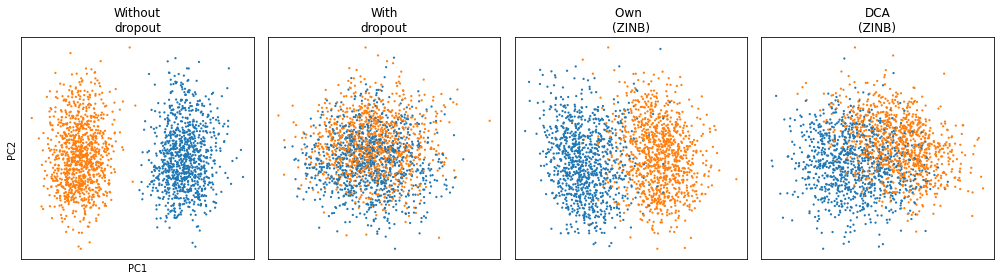

In [26]:
adatas = [sim_true_norm, sim_raw_norm, zinb_norm, dca_simraw2]
adata_labels = ['Without\ndropout', 'With\ndropout', "My Model", "DCA\n(ZINB)"]

p.plot(adatas, adata_labels)

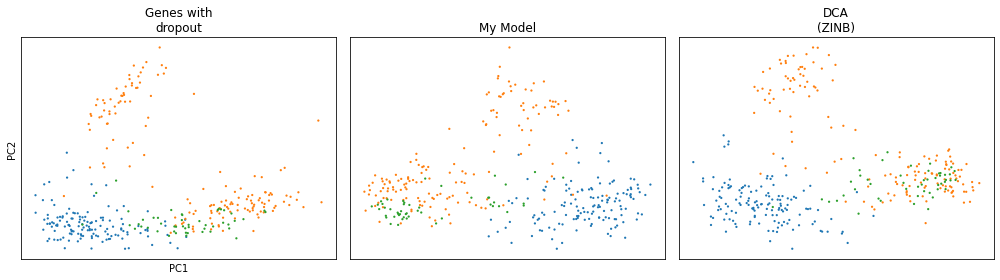

In [29]:
adatas = [genes_norm, zinb_genes_norm, dca_genes]
adata_labels = ["Genes with\ndropout", "My Model", "DCA\n(ZINB)"]

p.plot(adatas, adata_labels)

# Conclusion and discussion

**Summary**: In this project, we explored the use of a deep auto-encoder model for the task of denoising sc-RNA-seq data. Through experiments on simulated and real data, we can see that the method indeed improves cluster identification. Denoising has been shown to improve other biological tasks as well, including differential expression and protein and RNA co-expression analyses [1].  As sequencing technology develops to handle a higher number of cells with lower sequencing depth, the demand for more accurate and scalable denoising methods is expected to increase, ensuring the relevance of our solution.

**Areas for improvement**: The assumptions on the noise model can be relaxed as theoretical studies for RNA count distributions provide alternative hypotheses. The original DCA implementation [1] already provides at least 2 other noise distributions with a mechanism to automatically choose the most suitable one for the given data.  Furthermore, taking the imputation value to be the mean of a per-gene distribution cancels out the possibility of having differnet gene-per-cell counts in the data sample, which could limit the type of studies that can use this denoising method. 

**Future work**: Future work for this project includes re-implementing the loss function to fit the eager execution mode of TensorFlow 2.4.0. Hyperparameter tuning would also be needed to choose a suitable network architecture and parameters such as optimizer, learning rate etc. Finally, an experimental comparison with other (more recent) denoising solutions would provide a better sense of the capabilities of this method. Additionally, I would like to explore graphical plotting tools to draw the generative model of the problem programmatically.

# References

[1] Eraslan, G., Simon, L.M., Mircea, M. et al. Single-cell RNA-seq denoising using a deep count autoencoder. Nat Commun 10, 390 (2019). https://doi.org/10.1038/s41467-018-07931-2

[2] Lopez, R., Regier, J., Cole, M. B., Jordan, M. & Yosef, N. Bayesian inference for a generative model of transcriptome profiles from single-cell RNA sequencing. Preprint at bioRxiv https://doi.org/10.1101/292037 (2018).

[3] Chen, W. et al. UMI-count modeling and differential expression analysis for single-cell RNA sequencing. Genome Biol. 19, 70 (2018).

[4] Zappia L, Phipson B, Oshlack A. Splatter: Simulation Of Single-Cell RNA Sequencing Data. Genome Biology. 2017; doi:10.1186/s13059-017-1305-0.

[5] van Dijk, D. et al MAGIC: a diffusion-based imputation method reveals gene- gene interactions in single-cell RNA-sequencing data. bioRxiv (2017).

[6] Huang, M. et al. SAVER: gene expression recovery for single-cell RNA sequencing. Nat. Methods 15, 539–542 (2018).

[7] Li, W. V. & Li, J. J. An accurate and robust imputation method scImpute for single-cell RNA-seq data. Nat. Commun. 9, 997 (2018).
23.

[8] Angerer, P. et al. Single cells make big data: New challenges and opportunities in transcriptomics. Curr. Opin. Syst. Biol. 4,85–91 (2017).
14.